# NYC Taxi Dataset 2023 EDA
### Author: Sam Alavi


## Executive Summary

This notebook presents an exploratory data analysis (EDA) of NYC Yellow Taxi trip data from 2023, containing over 34 million records. The analysis focuses on understanding fare patterns, temporal trends, and spatial distributions to inform machine learning model development for fare prediction.

### Dataset Overview
- **Size**: 34,009,543 trips after outlier removal
- **Time Period**: January - December 2023
- **Target Variable**: `fare_amount` (metered base fare, excluding surcharges and tips)
- **Key Features**: Trip distance, temporal features, location IDs, passenger count

### Key Findings

**Temporal Patterns:**
- Clear rush hour effects (7-9 AM, 5-7 PM)
- Weekday vs weekend variations in trip volume and fares
- Monthly seasonality in demand and revenue

**Fare Characteristics:**
- **Mean fare**: $16.78
- **Median fare**: $12.80
- **Strong correlation** with trip distance (r = 0.954)
- Outliers removed using 0.1% and 99.9% quantiles

**Spatial Patterns:**
- Manhattan dominates both pickup and dropoff locations
- Distinct fare patterns across boroughs
- Airport trips (EWR) show different pricing dynamics

**Rush Hour Impact:**
- Rush hours account for 31% of total trips (10.6M vs 23.6M non-rush)
- **Lower average fares during rush hour** ($16.28 vs $17.23 non-rush)
- Likely due to shorter, more congested trips during peak times

### Analysis Structure
1. **Data Quality**: Outlier removal and statistical summaries
2. **Temporal Analysis**: Daily, monthly, weekday, and hourly patterns
3. **Correlation Analysis**: Relationship between fare and distance
4. **Categorical Analysis**: Rush hour and weekend effects
5. **Spatial Analysis**: Borough-level pickup/dropoff patterns

### Next Steps
This EDA informs feature engineering and model selection for fare prediction:
- Use `fare_amount` as target (exclude static surcharges)
- Include temporal features (hour, day of week, month)
- Consider location-based features (borough, zone)
- Model trip distance as primary predictor
- Account for rush hour and weekend effects

---

### Import Libraries

In [3]:
import polars as pl
import pandas as pd

### Load Dataset

- To manage memory efficiently, the dataset is loaded as a **lazy dataframe**
- Lazy evaluation delays computation until explicitly needed (via `.collect()`)
- This approach allows working with large datasets (34M+ rows) without loading everything into memory
- Operations are optimized and executed only when results are required

In [4]:
df = pl.scan_parquet('../data/processed/cleaned_data.parquet', low_memory=True)

### Initial Data Quality Assessment

**Before Outlier Removal:**
- Maximum fare: $386,983.63 (clearly erroneous - likely system error or data entry mistake)
- Maximum trip distance: 17,456.83 miles (impossible for NYC taxi trip)
- High standard deviation indicates presence of extreme outlier

In [5]:
print(df.select(pl.col(['fare_amount', 'trip_distance'])).describe())

shape: (9, 3)
┌────────────┬─────────────┬───────────────┐
│ statistic  ┆ fare_amount ┆ trip_distance │
│ ---        ┆ ---         ┆ ---           │
│ str        ┆ f64         ┆ f64           │
╞════════════╪═════════════╪═══════════════╡
│ count      ┆ 3.4160167e7 ┆ 3.4160167e7   │
│ null_count ┆ 0.0         ┆ 0.0           │
│ mean       ┆ 16.934504   ┆ 2.841214      │
│ std        ┆ 71.700032   ┆ 24.829941     │
│ min        ┆ 0.01        ┆ 0.01          │
│ 25%        ┆ 9.3         ┆ 1.05          │
│ 50%        ┆ 12.8        ┆ 1.71          │
│ 75%        ┆ 19.8        ┆ 3.01          │
│ max        ┆ 386983.63   ┆ 17456.83      │
└────────────┴─────────────┴───────────────┘


**Outlier Removal Strategy:**
- Remove values below 0.1% percentile and above 99.9% percentile
- This eliminates data quality issues while preserving 99.8% of legitimate trips
- Ensures robust analysis and prevents model distortion from anomalous data


In [6]:
def remove_outlier(df: pl.LazyFrame, cols: list, p=0.001):
    for col in cols:
        lower_bound = df.select(pl.col(col).quantile(p))
        higher_bound = df.select(pl.col(col).quantile(1-p))
        df = df.filter(
            (pl.col(col) < higher_bound.collect().item()) &  
            (pl.col(col) > lower_bound.collect().item())
        )
    return df

df = remove_outlier(df, cols=['fare_amount', 'trip_distance'])

print(df.select(pl.col(['fare_amount', 'trip_distance'])).describe())

shape: (9, 3)
┌────────────┬─────────────┬───────────────┐
│ statistic  ┆ fare_amount ┆ trip_distance │
│ ---        ┆ ---         ┆ ---           │
│ str        ┆ f64         ┆ f64           │
╞════════════╪═════════════╪═══════════════╡
│ count      ┆ 3.4009543e7 ┆ 3.4009543e7   │
│ null_count ┆ 0.0         ┆ 0.0           │
│ mean       ┆ 16.782709   ┆ 2.736712      │
│ std        ┆ 11.887123   ┆ 2.917268      │
│ min        ┆ 3.03        ┆ 0.11          │
│ 25%        ┆ 9.3         ┆ 1.05          │
│ 50%        ┆ 12.8        ┆ 1.71          │
│ 75%        ┆ 19.8        ┆ 3.0           │
│ max        ┆ 96.1        ┆ 21.7          │
└────────────┴─────────────┴───────────────┘


### Visualization libraries and setting themes

In [7]:
import seaborn as sns
sns.set_theme(style="darkgrid", 
              palette=sns.color_palette("deep"))

import numpy as np
import matplotlib.pyplot as plt

### Daily Trip Volume Analysis (2023)

**Key Observations:**
- **September 21-25 gap**: Significant drop in trips corresponds to severe weather events (Hurricane Ophelia remnants affected NYC during this period)
- **Summer decline**: Gradual decrease in trip volume during June-August, likely due to:
  - Better weather encouraging walking/cycling
  - Vacation season reducing commuter traffic
  - Residents leaving the city for summer holidays
- **Christmas period drop**: Sharp decline around December 25th reflects reduced business activity and work commutes during the holiday season
- **Red dashed line**: Represents the daily average trip count as a baseline for comparison

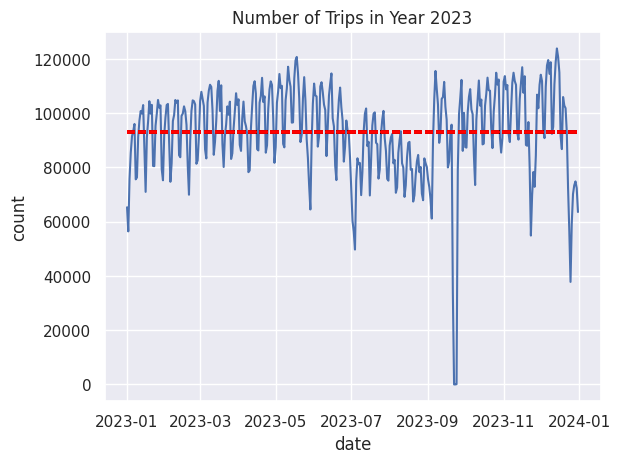

In [8]:
trip_trend = df.select(
    pl.col("tpep_pickup_datetime").dt.strftime("%Y-%m-%d").alias('date'),
    pl.col('fare_amount')
).group_by(pl.col('date')).agg(
    pl.len().alias('count'),
    pl.sum('fare_amount').alias('total_profit')
).collect().to_pandas()

trip_trend['date'] = pd.to_datetime(trip_trend['date'])
trip_trend.sort_values(by='date', inplace=True)

ax = sns.lineplot(data=trip_trend, x='date', y='count',)
ax.hlines(np.repeat(trip_trend['count'].mean(), trip_trend.shape[0]),
          xmin=trip_trend['date'].min(), xmax=trip_trend['date'].max(),
          colors='red', linestyles='--')
ax.set_title('Number of Trips in Year 2023')
plt.show()

### Time Series Decomposition

**Purpose**: Decompose daily trip count into trend, seasonal, and residual components to understand underlying patterns.

**Key Observations:**

**Trend Component (Orange):**
- **Stable baseline**: ~95,000-105,000 trips/day throughout most of 2023
- **Summer decline**: Gradual decrease June-August (vacation season)
- **September drop**: Sharp decline to ~70,000 trips (Hurricane Ophelia impact)
- **Year-end decline**: December shows downward trend (holiday season)

**Seasonal Component (Green):**
- **Weekly pattern**: Clear 7-day cycle with amplitude of ~20,000 trips
- **Consistent oscillation**: Weekday peaks vs weekend troughs
- **Regular pattern**: No major disruptions to weekly seasonality throughout the year

**Residual Component (Red):**
- **Low noise**: Most residuals stay within ±10,000 range
- **Anomalies detected**:
  - **September spike**: Hurricane Ophelia caused major deviation (-50,000)
  - **November outliers**: Possible weather events or holidays
- **Generally stable**: Indicates model captures most patterns well

**Insights for Modeling:**
- Strong weekly seasonality should be included as a feature
- Trend component suggests need for month/season features
- Low residuals indicate good decomposition fit
- Weather events create unpredictable anomalies (consider external data)

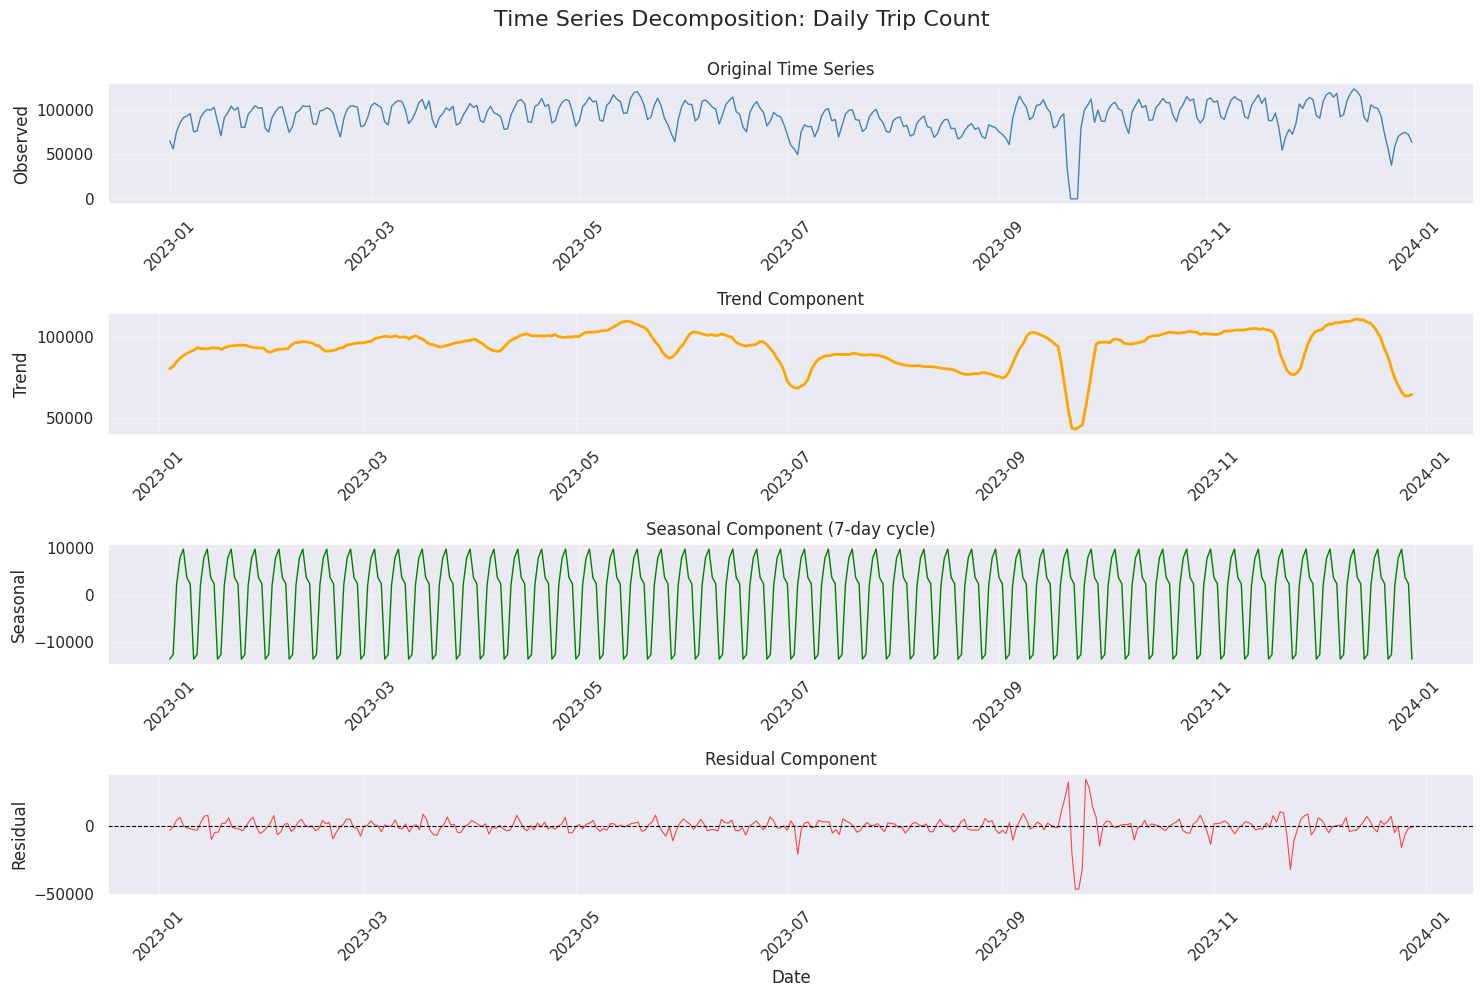

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts_data = pd.Series(trip_trend['count'].values, index=trip_trend['date'])

decomposition_obj = seasonal_decompose(ts_data, model='additive', period=7)

fig, axes = plt.subplots(nrows=4, figsize=(15, 10))
fig.suptitle('Time Series Decomposition: Daily Trip Count', fontsize=16, y=0.995)

axes[0].plot(ts_data.index, ts_data.values, color='steelblue', linewidth=1)
axes[0].set_ylabel('Observed', fontsize=12)
axes[0].set_title('Original Time Series')
axes[0].grid(True, alpha=0.3)

axes[1].plot(decomposition_obj.trend.index, decomposition_obj.trend.values, color='orange', linewidth=2)
axes[1].set_ylabel('Trend', fontsize=12)
axes[1].set_title('Trend Component')
axes[1].grid(True, alpha=0.3)

axes[2].plot(decomposition_obj.seasonal.index, decomposition_obj.seasonal.values, color='green', linewidth=1)
axes[2].set_ylabel('Seasonal', fontsize=12)
axes[2].set_title('Seasonal Component (7-day cycle)')
axes[2].grid(True, alpha=0.3)

axes[3].plot(decomposition_obj.resid.index, decomposition_obj.resid.values, color='red', linewidth=0.8, alpha=0.7)
axes[3].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[3].set_ylabel('Residual', fontsize=12)
axes[3].set_xlabel('Date', fontsize=12)
axes[3].set_title('Residual Component')
axes[3].grid(True, alpha=0.3)


for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

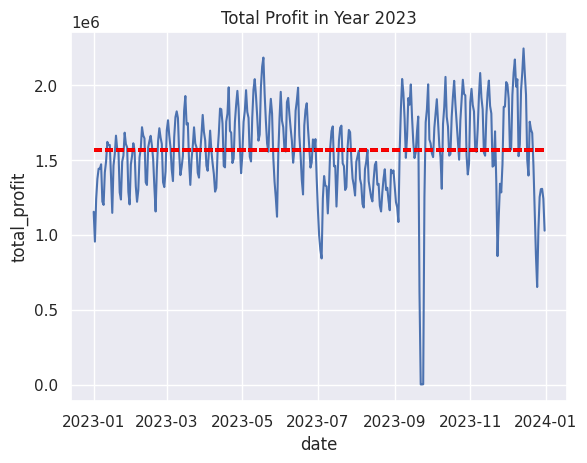

In [9]:
ax = sns.lineplot(data=trip_trend, x='date', y='total_profit',)
ax.hlines(np.repeat(trip_trend['total_profit'].mean(), trip_trend.shape[0]),
          xmin=trip_trend['date'].min(), xmax=trip_trend['date'].max(),
          colors='red', linestyles='--')
ax.set_title('Total Profit in Year 2023')
plt.show()

### Monthly Trip and Fare Analysis

**Trip Volume Patterns:**
- **Peak demand**: March and October show highest trip counts (~3.1M trips each)
- **Lowest demand**: September (2.49M trips) - impacted by Hurricane Ophelia
- **Pattern**: Two peaks in spring (March) and fall (October), with summer dip

**Average Fare Trends:**
- **Progressive increase**: Fares gradually rise throughout the year
- **Lowest fares**: January-February (~$15.94-$16.01) 
- **Highest fares**: September (~$17.84) despite lowest trip volume
- **Fall/Winter**: Consistently higher fares ($17.19-$17.84) from September onward

**Key Insights:**
- **September anomaly**: Lowest trip count but highest average fare suggests:
  - Weather disruptions eliminated short trips
  - Only essential/longer trips were taken during the storm
  - Reduced supply (fewer drivers) may have increased prices
- **Seasonal pattern**: Higher fares in fall/winter likely due to less walking and longer trips

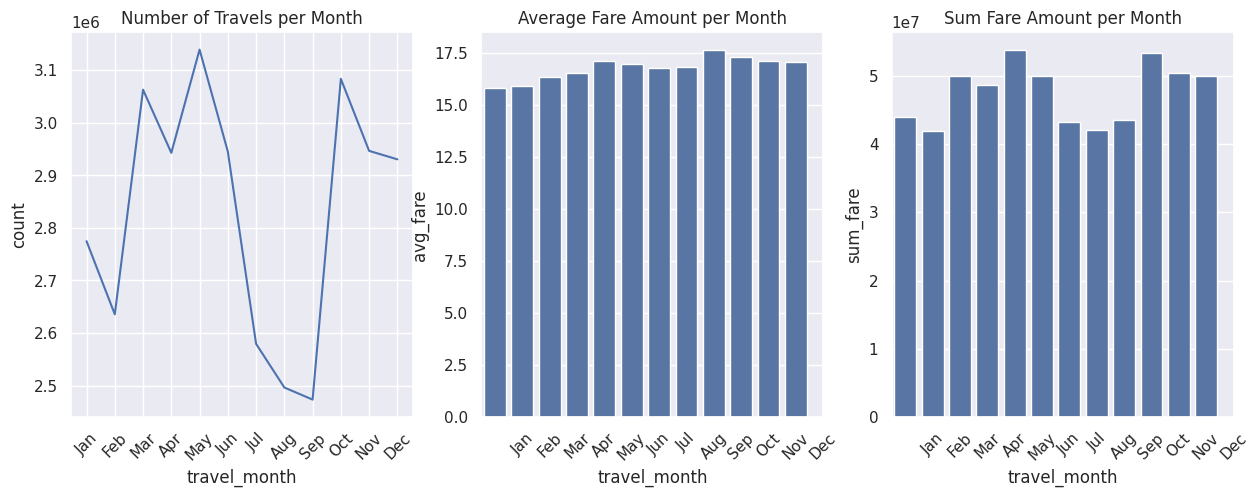

In [10]:
fare_by_month = df.select(
    pl.col('fare_amount'),
    pl.col('travel_month')
).group_by('travel_month').agg(
    pl.col('fare_amount').mean().alias('avg_fare'),
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.len().alias('count')
).collect().to_pandas()


fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
month_labels = [
    'Jan', 'Feb', 'Mar',
    'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep',
    'Oct', 'Nov', 'Dec'
]

# Line plot for count of travels per month
sns.lineplot(data=fare_by_month, x='travel_month', 
             y='count', ax=axes[0])
axes[0].set_title('Number of Travels per Month')

# Bar plot for average fare per month
sns.barplot(data=fare_by_month, x='travel_month',
            y='avg_fare', ax=axes[1])
axes[1].set_title('Average Fare Amount per Month')

# Line plot for total profit per month
sns.barplot(data=fare_by_month, x='travel_month',
            y='sum_fare', ax=axes[2])
axes[2].set_title('Sum Fare Amount per Month')

for ax in axes: 
    ax.set_xticks(range(1, len(month_labels) + 1))
    ax.set_xticklabels(month_labels, rotation=45)
plt.show()

### Weekday Trip Patterns

**Trip Volume by Day:**
- **Lowest demand**: Sunday (4.24M) and Monday (4.21M trips)
- **Peak demand**: Thursday (5.38M trips) - highest trip count
- **Weekday pattern**: Gradual increase from Monday → Thursday, then decline into weekend
- **Weekend effect**: Saturday (5.00M) maintains relatively high volume, Sunday drops significantly

**Average Fare Trends:**
- **Highest fares**: Thursday ($17.25) and Sunday ($17.10)
- **Lowest fares**: Saturday ($16.26) - 6% lower than Thursday
- **Weekday stability**: Monday-Thursday maintain consistent fares (~$17.01-$17.25)
- **Friday drop**: Begins weekend fare decline ($16.81)

**Key Insights:**
- **Monday pattern**: Post-pandemic remote work culture likely reduces Monday commutes
- **Thursday peak**: Highest activity as people complete work-week commitments before Friday
- **Saturday discount**: Lower fares despite high trip volume suggest shorter, non-commute trips (entertainment, shopping)
- **Sunday characteristics**: Lowest volume but higher fares indicate longer, more purposeful trips

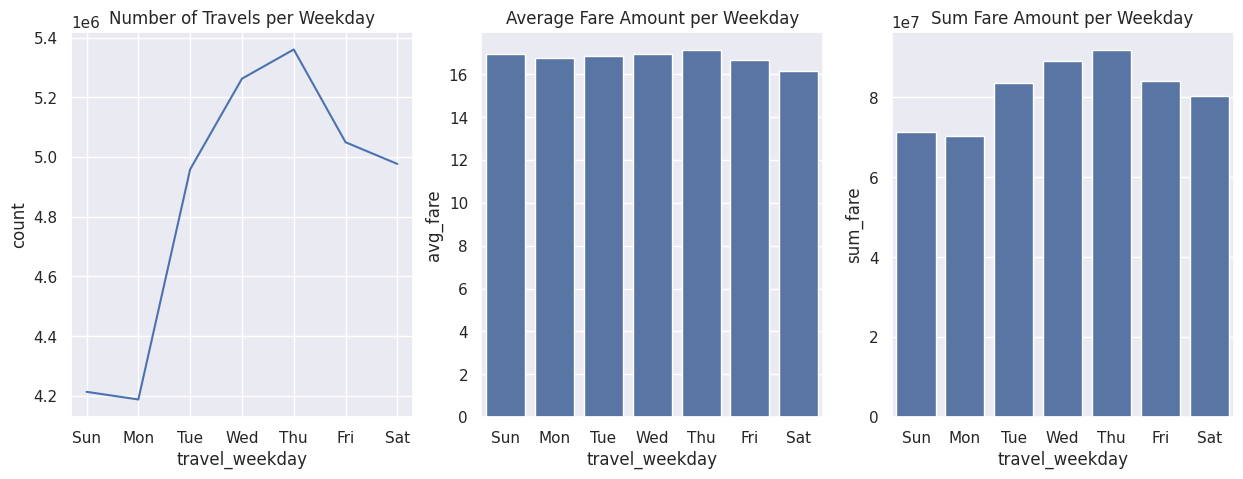

In [11]:
weekday_labels = [
    'Sun', 'Mon', 'Tue', 'Wed',
    'Thu', 'Fri', 'Sat'
]

fare_by_weekday = df.select(
    pl.col('fare_amount'),
    pl.col('travel_weekday')
).group_by('travel_weekday').agg(
    pl.col('fare_amount').mean().alias('avg_fare'),
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.len().alias('count')
).collect().to_pandas()


fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

# Line plot for count of travels per Weekday
sns.lineplot(data=fare_by_weekday, x='travel_weekday', 
             y='count', ax=axes[0])
axes[0].set_title('Number of Travels per Weekday')

# Bar plot for average fare per Weekday
sns.barplot(data=fare_by_weekday, x='travel_weekday',
            y='avg_fare', ax=axes[1])
axes[1].set_title('Average Fare Amount per Weekday')

# Line plot for total profit per Weekday
sns.barplot(data=fare_by_weekday, x='travel_weekday',
            y='sum_fare', ax=axes[2])
axes[2].set_title('Sum Fare Amount per Weekday')

for ax in axes:
    ax.set_xticks(range(0, len(weekday_labels)))
    ax.set_xticklabels(weekday_labels)

plt.show()

### Day of Month Analysis

**Trip Volume Pattern (Left Plot):**
- **Days 1-25**: Consistent trip volume (~1.1-1.2M trips per day)
- **Days 26-31**: Significant decline, especially days 29-31 (drops to ~0.6-0.8M)
- **Explanation**: This decline is a **data artifact**, not a real pattern:
  - February has only 28 days
  - April, June, September, November have only 30 days
  - Therefore, days 29-31 have fewer months contributing data → artificially lower totals

**Average Fare Pattern (Middle Plot):**
- **No meaningful pattern**: Fares remain consistent across all days (~$16.50-$17.50)
- **Key insight**: Day of month has no predictive value for fare amounts
- This confirms that fare pricing is driven by time-of-day, location, and distance—not calendar date

**Sum Fare Pattern (Right Plot):**
- Mirrors the trip count pattern (left plot) for the same reasons

**Conclusion:** Day of month is **not a useful feature** for fare prediction modeling. Focus should remain on weekday, hour, month, and location-based features.

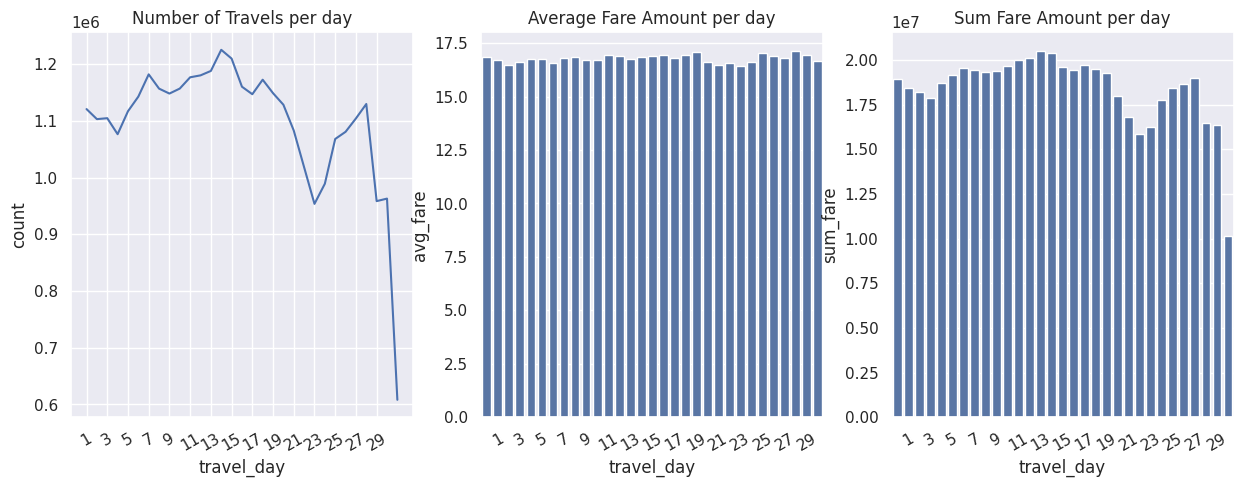

In [12]:
fare_by_day = df.select(
    pl.col('fare_amount'),
    pl.col('travel_day')
).group_by('travel_day').agg(
    pl.col('fare_amount').mean().alias('avg_fare'),
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.len().alias('count')
).collect().to_pandas()


fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

# Line plot for count of travels per day
sns.lineplot(data=fare_by_day, x='travel_day', 
             y='count', ax=axes[0])
axes[0].set_title('Number of Travels per day')

# Bar plot for average fare per day
sns.barplot(data=fare_by_day, x='travel_day',
            y='avg_fare', ax=axes[1])
axes[1].set_title('Average Fare Amount per day')

# Line plot for total profit per day
sns.barplot(data=fare_by_day, x='travel_day',
            y='sum_fare', ax=axes[2])
axes[2].set_title('Sum Fare Amount per day')

for ax in axes:
    ax.set_xticks(range(1, 31, 2))
    ax.set_xticklabels(range(1, 31, 2), rotation=30)

plt.show()

### Hourly Trip Patterns

**Trip Volume by Hour (Left Plot):**
- **Overnight low**: 4-5 AM shows lowest demand (~500K trips)
- **Morning rush**: 7-9 AM surge, peaking around 8-9 AM
- **Lunch peak**: Slight increase around noon-1 PM
- **Evening rush**: 5-7 PM shows highest demand (~1.8M trips at 6 PM)
- **Late evening**: Gradual decline after 8 PM, but remains elevated until midnight

**Average Fare by Hour (Middle Plot):**
- **Highest fares**: Early morning hours 4-6 AM (~$17.50+) - likely longer trips, airport runs
- **Rush hour paradox**: 7-9 AM and 5-7 PM show slightly lower fares despite high demand
- **Afternoon**: 12 PM - 4 PM maintains moderate fares (~$16.50-$17.00)
- **Late night premium**: After 10 PM fares increase, peaking in early morning

**Key Insights:**
- **Demand-fare disconnect**: Highest demand doesn't correlate with highest fares
- **Early morning premium**: 4-6 AM trips are longer and more expensive (airport, shift workers)
- **Rush hour efficiency**: Despite congestion, rush hour trips are shorter in distance
- **Time-of-day is critical**: Hour is a strong predictor for both volume and fare patterns

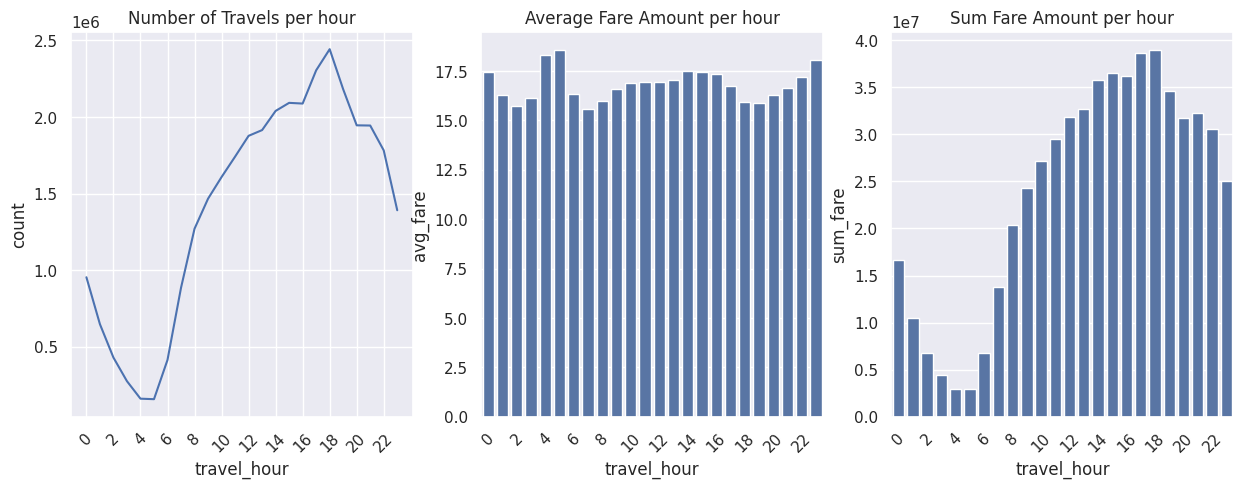

In [13]:
fare_by_hour = df.select(
    pl.col('fare_amount'),
    pl.col('travel_hour')
).group_by('travel_hour').agg(
    pl.col('fare_amount').mean().alias('avg_fare'),
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.len().alias('count')
).collect().to_pandas()


fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

# Line plot for count of travels per hour
sns.lineplot(data=fare_by_hour, x='travel_hour', 
             y='count', ax=axes[0])
axes[0].set_title('Number of Travels per hour')

# Bar plot for average fare per hour
sns.barplot(data=fare_by_hour, x='travel_hour',
            y='avg_fare', ax=axes[1])
axes[1].set_title('Average Fare Amount per hour')

# Line plot for total profit per hour
sns.barplot(data=fare_by_hour, x='travel_hour',
            y='sum_fare', ax=axes[2])
axes[2].set_title('Sum Fare Amount per hour')

for ax in axes:
    ax.set_xticks(range(0, 24, 2))
    ax.set_xticklabels(range(0, 24, 2), rotation=45)

plt.show()

### Correlation Analysis: Fare Amount vs Trip Distance

**Correlation Coefficient: 0.954**

This represents a **very strong positive linear relationship** between trip distance and fare amount.

**Interpretation:**
- 95.4% correlation indicates trip distance is the dominant factor in fare calculation
- This aligns with NYC taxi meter structure:
  - Base fare calculation uses distance-based rate ($2.50 per mile)
  - Time-based rate applies only when speed < 12 mph
  - Result: Distance is primary fare determinant

**For Machine Learning:**
- Trip distance will be the **most important predictor** in any fare prediction model
- The remaining 4.6% variance likely explained by secondary factors:
  - Time of day (rush hour, late night)
  - Traffic conditions
  - Route efficiency
  - Location-based surcharges (airport, congestion zones)

In [14]:
df.select(
    pl.corr(
        'fare_amount',
        'trip_distance',
    )
).collect()

fare_amount
f64
0.95391


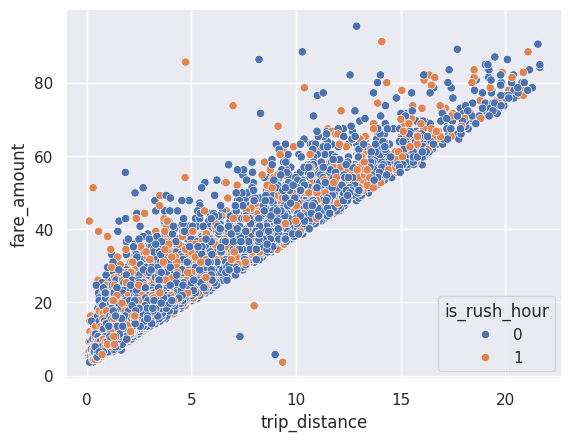

In [15]:
trip_fare = df.select(
    pl.col([
        'fare_amount',
        'trip_distance',
        'is_rush_hour',
        'is_weekend'
    ])
).collect().sample(fraction=0.001).to_pandas()

sns.scatterplot(data=trip_fare, x='trip_distance', y='fare_amount', hue='is_rush_hour')
plt.show()

### Rush Hour Impact Analysis

**Trip Volume (Middle Plot):**
- **Non-rush hours (0)**: 23.6M trips - 69% of all trips
- **Rush hours (1)**: 10.6M trips - 31% of all trips
- Rush hours (7-9 AM, 5-7 PM) represent only 6 hours per day but account for nearly 1/3 of daily trips

**Average Fare (Right Plot):**
- **Non-rush hours (0)**: $17.23 average fare
- **Rush hours (1)**: $16.28 average fare
- **Surprising result**: Rush hour fares are **$0.95 lower** (5.5% decrease)

**Total Revenue (Left Plot):**
- **Non-rush hours (0)**: $406M total revenue
- **Rush hours (1)**: $172M total revenue

**Key Insight:**
Rush hour trips have **lower average fares** despite higher demand. This counter-intuitive finding suggests:
- Rush hour trips are shorter in distance (commute trips within city)
- Traffic congestion doesn't increase fares enough to offset shorter distances
- Non-rush trips include more airport runs and longer-distance journeys

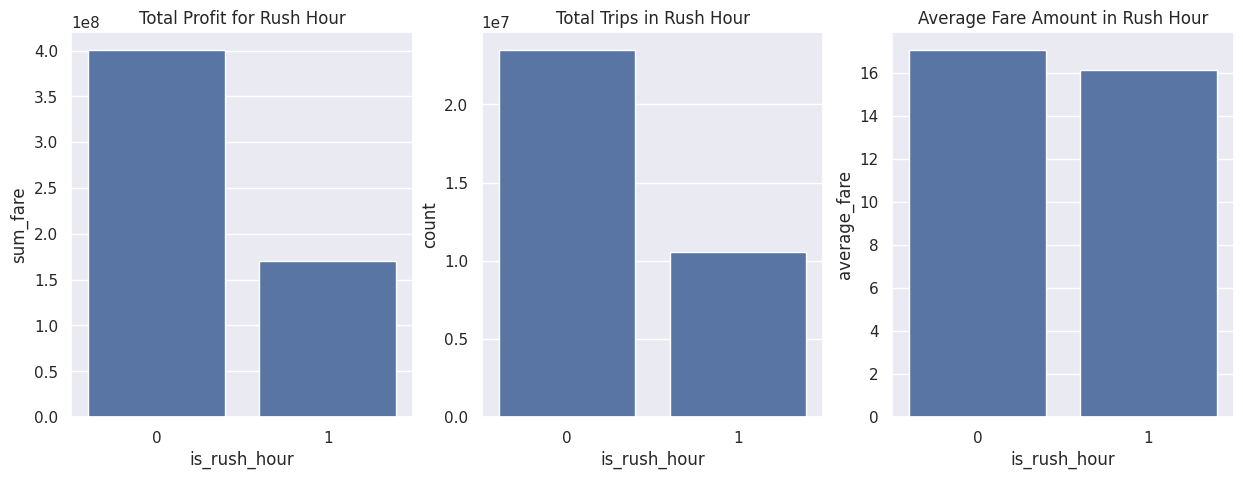

In [16]:
rush_hour_agg = df.select(
    pl.col([
        'is_rush_hour',
        'fare_amount'
    ])
).group_by('is_rush_hour').agg(
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.len().alias('count'),
    pl.col('fare_amount').mean().alias('average_fare')
).collect().to_pandas()

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

sns.barplot(rush_hour_agg, x='is_rush_hour', y='sum_fare', ax=axes[0])
axes[0].set_title('Total Profit for Rush Hour')

sns.barplot(rush_hour_agg, x='is_rush_hour', y= 'count', ax=axes[1])
axes[1].set_title('Total Trips in Rush Hour')

sns.barplot(rush_hour_agg, x='is_rush_hour', y='average_fare', ax=axes[2])
axes[2].set_title('Average Fare Amount in Rush Hour')

plt.show()


### Pickup Location Analysis by Borough

**Trip Volume (Right Plot):**
- **Manhattan dominates**: 30.6M trips (90% of all pickups)
- **Queens**: 2.1M trips (6% of pickups)
- **Other boroughs**: Minimal pickup activity (<1% each)
- **Explanation**: NYC yellow taxis are primarily licensed to pick up street hails in Manhattan and airports

**Average Fare by Pickup Location (Left Plot):**
- **Highest fares**:
  - **Queens**: $43.34 - includes JFK and LaGuardia airport pickups (long-haul trips)
  - **EWR** (Newark): $37.91 - airport trips to NYC
- **Manhattan**: $14.81 - lowest fares due to short intra-borough trips
- **Bronx**: $22.32 - medium-distance trips
- **Brooklyn**: $22.05 - cross-borough commutes

**Key Insights:**
- **Airport effect**: Queens and EWR command 2-3x higher fares due to long-distance airport trips
- **Manhattan paradox**: Highest trip volume but lowest average fare (short distances within the borough)
- **Regulatory context**: Yellow taxi pickup restrictions create concentrated Manhattan demand
- **For ML modeling**: Pickup borough is a strong fare predictor, especially for airport zones

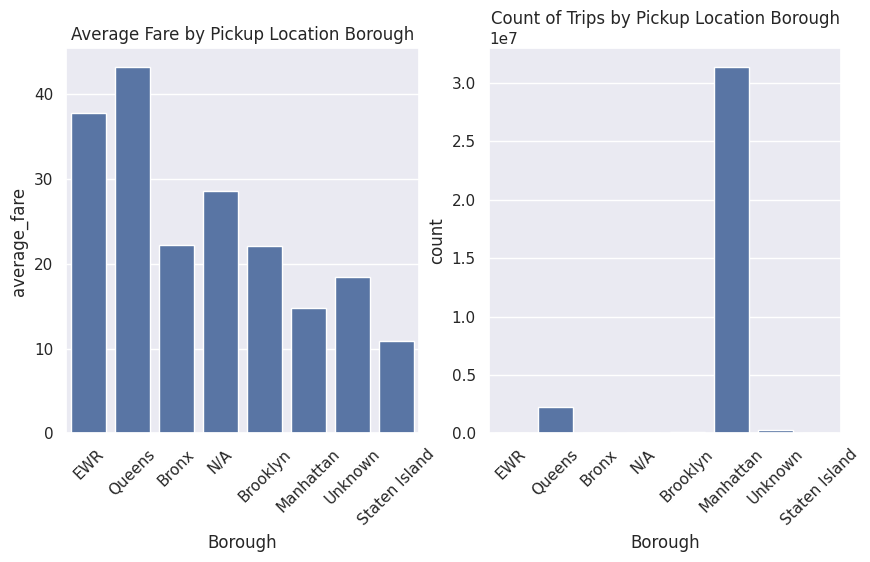

In [17]:

pickup_stats = df.select(
    pl.col([
        'PULocationID',
        'fare_amount',
        'trip_distance'
    ])
).join(
    pl.scan_csv('../data/lookups/taxi_zone_lookup.csv'),
    left_on='PULocationID',
    right_on='LocationID'
).group_by('Borough').agg(
    pl.col('fare_amount').mean().alias('average_fare'),
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.col('trip_distance').mean().alias('average_distance'),
    pl.len().alias('count')
).collect().to_pandas()


fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

sns.barplot(pickup_stats, x='Borough', y='average_fare', ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Average Fare by Pickup Location Borough')

sns.barplot(pickup_stats, x='Borough', y='count', ax=axes[1])
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Count of Trips by Pickup Location Borough')
plt.show()


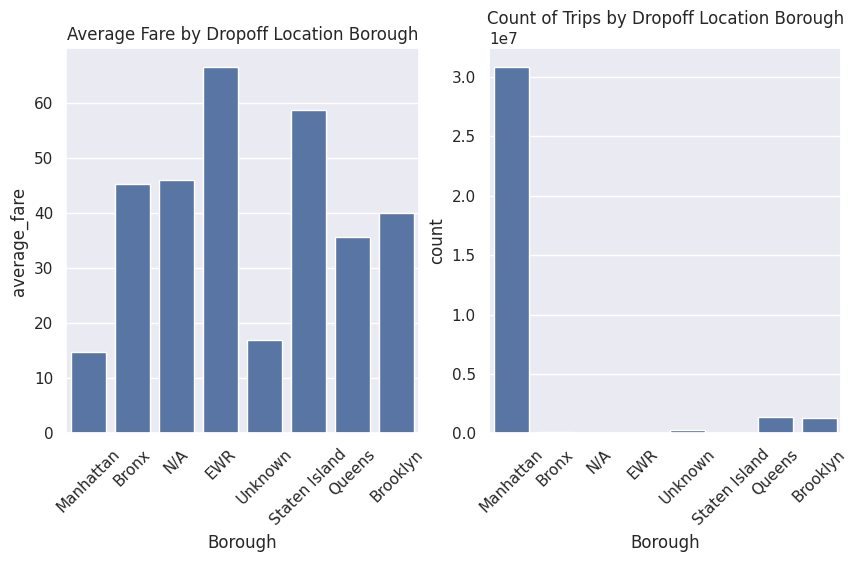

In [18]:

dropoff_stats = df.select(
    pl.col([
        'DOLocationID',
        'fare_amount',
        'trip_distance'
    ])
).join(
    pl.scan_csv('../data/lookups/taxi_zone_lookup.csv'),
    left_on='DOLocationID',
    right_on='LocationID'
).group_by('Borough').agg(
    pl.col('fare_amount').mean().alias('average_fare'),
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.col('trip_distance').mean().alias('average_distance'),
    pl.len().alias('count')
).collect().to_pandas()


fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

sns.barplot(dropoff_stats, x='Borough', y='average_fare', ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Average Fare by Dropoff Location Borough')

sns.barplot(dropoff_stats, x='Borough', y='count', ax=axes[1])
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Count of Trips by Dropoff Location Borough')
plt.show()


## Feature Engineering

### Route-based Features
- **route_mean_distance**: Average trip distance for each pickup-dropoff location pair (calculated using window function over `PULocationID` and `DOLocationID`)
- **distance_ratio**: Ratio of actual trip distance to the route's average distance (values > 1 indicate longer than typical routes)
- **fare_per_mile**: Fare amount divided by trip distance ($/mile rate)

In [19]:
df = df.with_columns(
    pl.col('trip_distance').mean().over(['PULocationID', 'DOLocationID']).alias('route_mean_distance')
).with_columns(
    (pl.col('trip_distance')/pl.col('route_mean_distance')).alias('distance_ratio'),
    (pl.col('fare_amount') / pl.col('trip_distance')).alias('fare_per_mile')
)

### Time-based Features
- **trip_duration**: Duration of the trip in minutes (calculated from pickup to dropoff datetime)
- **avg_speed**: Average speed in miles per minute (trip_distance / trip_duration)
- **fare_per_minute**: Fare rate per minute of travel time

In [20]:
df = df.with_columns(
    (pl.col('tpep_dropoff_datetime') - pl.col('tpep_pickup_datetime')).dt.total_minutes().alias('trip_duration')
).with_columns(
    (pl.col('trip_distance') / pl.col('trip_duration')).alias('avg_speed'),
    (pl.col('fare_amount') / pl.col('trip_duration')).alias('fare_per_minute')
)

### Trip Duration vs Fare Amount Analysis

After removing outliers from trip duration, we analyzed the relationship between trip duration and fare amount using a scatter plot of 1,000 sampled trips.

**Key Observations:**
- Strong positive correlation between trip duration and fare amount
- Most trips cluster in the 10-40 minute range with fares between $10-$50
- Linear relationship suggests fare is primarily time-based
- Few trips exceed 60 minutes or $80 in fare

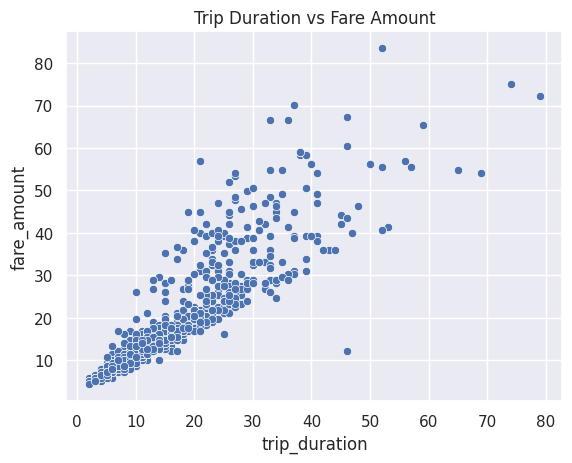

In [21]:
df = remove_outlier(df, cols=['trip_duration', 'distance_ratio'])

num_features = df.select(
    pl.col(['trip_duration', 'fare_amount', 'trip_distance', 'avg_speed',
            'fare_per_minute', 'fare_per_mile', 'distance_ratio'])
).collect().to_pandas()

sns.scatterplot(num_features.sample(1000), x='trip_duration', y='fare_amount')
plt.title('Trip Duration vs Fare Amount')
plt.show()

### Distance Ratio Distribution

Distribution of the distance ratio (actual trip distance / route average distance) shows how individual trips compare to typical distances for each route.

**Key Observations:**
- Normal distribution centered around 1.0, indicating most trips follow typical route distances
- Majority of trips fall between 0.8-1.2x the average route distance
- Slight right skew with some trips extending to 2-4x the typical distance
- This feature can help identify unusually long or short trips for the same pickup-dropoff pair

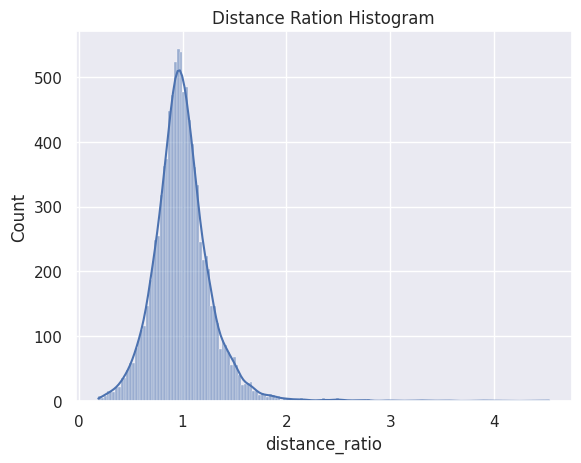

In [25]:
sns.histplot(data=num_features.sample(10000), x='distance_ratio', kde=True)
plt.title('Distance Ration Histogram')
plt.show()

### Trip Duration Distribution

Histogram showing the distribution of trip durations (in minutes) after outlier removal.

**Key Observations:**
- Right-skewed distribution with a strong peak around 10-15 minutes
- Majority of trips are short-duration (under 30 minutes)
- Long tail extending to 60+ minutes, indicating some longer trips remain
- Median trip duration appears to be around 10-12 minutes
- Distribution suggests most NYC taxi trips are relatively short, urban journeys

**Note for Modeling:**
- **Scaling required**: This feature shows high variance and skewness
- Consider log transformation or StandardScaler/RobustScaler before feeding to model
- Right skew may benefit from `np.log1p()` transformation to normalize distribution

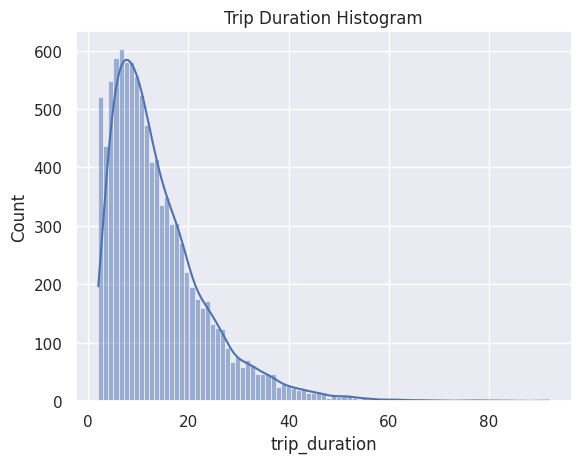

In [23]:
sns.histplot(data=num_features.sample(10000), x='trip_duration', kde=True)
plt.title('Trip Duration Histogram')
plt.show()

### Trip Duration Per Hour

**Key Observations:**
- **Early morning (0-6 AM)**: ~13 minutes average duration - light traffic allows faster trips
- **Morning decline (7-11 AM)**: Drops to ~11 minutes - short commute trips dominate
- **Midday peak (12-7 PM)**: 14-16 minutes - longest trips of the day (leisure, business, airport runs)
- **Evening rush (5-7 PM)**: ~15-16 minutes - 4 minutes longer than morning rush due to heavier congestion
- **Late evening (8 PM+)**: Gradually decreases back to ~13 minutes

**Key Insight:**
- Duration is **highest during midday** (not rush hour), suggesting longer-distance trips
- Fare is more strongly correlated with **distance** than duration (confirming NYC meter structure)

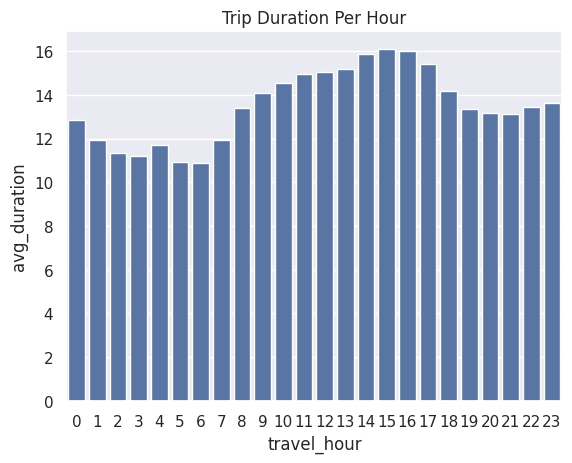

In [30]:
per_hour_duration = df.select(
    pl.col([
        'trip_duration', 'travel_hour'
    ])
).group_by('travel_hour').agg(
    pl.col('trip_duration').mean().alias('avg_duration')
).collect().to_pandas()

sns.barplot(data=per_hour_duration, x='travel_hour', y='avg_duration', orient='v')
plt.title('Trip Duration Per Hour')
plt.show()



<!-- High-Value Engineered Features
1. Distance-Based Features
# Route efficiency
df['distance_ratio'] = df['trip_distance'] / df['route_mean_distance']
df['distance_deviation'] = abs(df['trip_distance'] - df['route_mean_distance'])
df['is_detour'] = (df['distance_ratio'] > 1.3).astype(int)

# Distance per minute (speed proxy when you have duration)
df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
df['avg_speed'] = df['trip_distance'] / (df['trip_duration_min'] + 0.01)  # avoid div by zero
df['fare_per_mile'] = df['fare_amount'] / (df['trip_distance'] + 0.01)
df['fare_per_minute'] = df['fare_amount'] / (df['trip_duration_min'] + 0.01)
2. Location-Based Features
# Borough features
df['same_borough'] = (df['pickup_borough'] == df['dropoff_borough']).astype(int)
df['to_manhattan'] = (df['dropoff_borough'] == 'Manhattan').astype(int)
df['from_manhattan'] = (df['pickup_borough'] == 'Manhattan').astype(int)
df['to_airport'] = df['DOLocationID'].isin([1, 132, 138]).astype(int)  # EWR, JFK, LGA
df['from_airport'] = df['PULocationID'].isin([1, 132, 138]).astype(int)

# High-demand zones (top 10% by trip count)
popular_pickup = df['PULocationID'].value_counts().head(26).index  # top 10%
df['popular_pickup'] = df['PULocationID'].isin(popular_pickup).astype(int)
3. Temporal Interaction Features
# Peak periods
df['morning_rush'] = ((df['travel_hour'] >= 7) & (df['travel_hour'] <= 9)).astype(int)
df['evening_rush'] = ((df['travel_hour'] >= 17) & (df['travel_hour'] <= 19)).astype(int)
df['late_night'] = ((df['travel_hour'] >= 22) | (df['travel_hour'] <= 5)).astype(int)

# Day type
df['is_friday'] = (df['travel_weekday'] == 5).astype(int)
df['is_sunday'] = (df['travel_weekday'] == 0).astype(int)

# Seasonal
df['is_summer'] = df['travel_month'].isin([6, 7, 8]).astype(int)
df['is_winter'] = df['travel_month'].isin([12, 1, 2]).astype(int)

# Combined temporal features
df['weekend_night'] = (df['is_weekend'] & df['late_night']).astype(int)
df['weekday_rush'] = ((1 - df['is_weekend']) & df['is_rush_hour']).astype(int)
4. Trip Complexity Features
# Distance bins
df['distance_category'] = pd.cut(df['trip_distance'], 
                                  bins=[0, 1, 3, 5, 10, 100],
                                  labels=['very_short', 'short', 'medium', 'long', 'very_long'])

# Passenger patterns
df['solo_rider'] = (df['passenger_count'] == 1).astype(int)
df['group_ride'] = (df['passenger_count'] >= 3).astype(int)
5. Historical Aggregates (Strong features!)
# Per pickup zone
zone_stats = df.groupby('PULocationID').agg({
    'fare_amount': ['mean', 'median', 'std'],
    'trip_distance': ['mean', 'median'],
    'trip_duration_min': 'mean'
}).reset_index()

# Per hour of day
hour_stats = df.groupby('travel_hour').agg({
    'fare_amount': 'mean',
    'trip_distance': 'mean'
}).reset_index()

# Join back
df = df.merge(zone_stats, on='PULocationID', suffixes=('', '_zone_avg'))
df = df.merge(hour_stats, on='travel_hour', suffixes=('', '_hour_avg'))
6. Cyclical Encoding (Important for NNs!)
# Hour (0-23)
df['hour_sin'] = np.sin(2 * np.pi * df['travel_hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['travel_hour'] / 24)

# Day of week (0-6)
df['weekday_sin'] = np.sin(2 * np.pi * df['travel_weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['travel_weekday'] / 7)

# Month (1-12)
df['month_sin'] = np.sin(2 * np.pi * (df['travel_month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['travel_month'] - 1) / 12)
7. Demand/Supply Proxy Features
# Trips per hour (demand indicator)
hourly_demand = df.groupby(['date', 'travel_hour']).size().reset_index(name='hourly_trip_count')
df = df.merge(hourly_demand, on=['date', 'travel_hour'])

# Zone-hour demand
zone_hour_demand = df.groupby(['PULocationID', 'travel_hour']).size().reset_index(name='zone_hour_demand')
df = df.merge(zone_hour_demand, on=['PULocationID', 'travel_hour'])
Priority Ranking (by expected impact):
Tier 1 - Must Have:
✅ trip_duration_min and avg_speed - extremely predictive
✅ route_mean_distance - you already discussed this
✅ to_airport / from_airport - huge fare impact
✅ Cyclical encoding (sin/cos) for hour, weekday, month
✅ same_borough - structural fare difference
Tier 2 - High Value:
✅ distance_ratio (efficiency indicator)
✅ morning_rush / evening_rush (more granular than is_rush_hour)
✅ late_night premium indicator
✅ fare_per_mile from zone/hour aggregates
✅ weekend_night interaction
Tier 3 - Nice to Have:
Popular pickup/dropoff zones
Distance categories
Seasonal indicators
Passenger count features
Feature Engineering Pipeline Suggestion:
def engineer_features(df):
    # 1. Duration-based (if you have timestamps)
    df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - 
                                df['tpep_pickup_datetime']).dt.total_seconds() / 60
    df['avg_speed'] = df['trip_distance'] / (df['trip_duration_min'] + 0.01)
    
    # 2. Route features
    df['distance_ratio'] = df['trip_distance'] / df['route_mean_distance']
    df['distance_deviation'] = abs(df['trip_distance'] - df['route_mean_distance'])
    
    # 3. Location features
    df['to_airport'] = df['DOLocationID'].isin([1, 132, 138]).astype(int)
    df['from_airport'] = df['PULocationID'].isin([1, 132, 138]).astype(int)
    df['same_borough'] = (df['pickup_borough'] == df['dropoff_borough']).astype(int)
    
    # 4. Temporal cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['travel_hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['travel_hour'] / 24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['travel_weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['travel_weekday'] / 7)
    
    # 5. Rush hour granularity
    df['morning_rush'] = ((df['travel_hour'] >= 7) & (df['travel_hour'] <= 9)).astype(int)
    df['evening_rush'] = ((df['travel_hour'] >= 17) & (df['travel_hour'] <= 19)).astype(int)
    df['late_night'] = ((df['travel_hour'] >= 22) | (df['travel_hour'] <= 5)).astype(int)
    
    return df
Most Important: If you don't have trip_duration yet, calculate it immediately - it's likely your second-best feature after distance! Would you like me to help you implement any of these features in your pipeline? -->

### Trip Duration Per Weekday

**Key Observations:**
- **Weekday pattern**: Mid-week (Tue-Thu) shows longest durations (~14.5 minutes)
- **Weekend effect**: Sunday and Saturday have shorter trips (~13.5 minutes)
- **Monday baseline**: Starts at ~13.8 minutes, gradually increases through the week
- **Thursday peak**: Highest average duration at ~15 minutes
- **Pattern**: Trips get progressively longer from Monday → Thursday, then decline into weekend

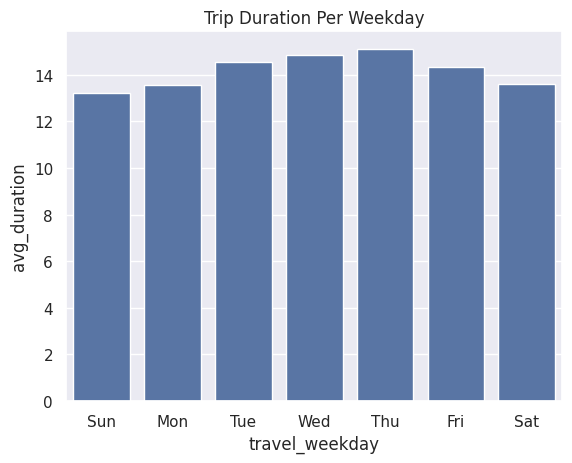

In [35]:
weekday_labels = [
    'Sun', 'Mon', 'Tue',
    'Wed', 'Thu', 'Fri', 'Sat'
]

per_weekday_duration = df.select(
    pl.col([
        'trip_duration', 'travel_weekday'
    ])
).group_by('travel_weekday').agg(
    pl.col('trip_duration').mean().alias('avg_duration')
).collect().to_pandas()

ax = sns.barplot(data=per_weekday_duration, x='travel_weekday', y='avg_duration', orient='v')
plt.title('Trip Duration Per Weekday')
ax.set_xticks(range(0, 7), weekday_labels)
plt.show()